In [1]:
import sys, os
sys.path.append('../MultiFishLSS/')
from headers import *
from twoPoint import *
from twoPointNoise import *
from classy import Class


# Compute $N_{\rm modes}$ and $V_{\rm eff}$ 

In [2]:
default_cosmo = {
        'output': 'tCl lCl mPk',
        'non linear':'halofit',
        'l_max_scalars': 4000,
        'lensing': 'yes',
        'P_k_max_h/Mpc': 2.,
        'z_pk': '0.0,1087',
        'A_s': 2.10732e-9,
        'n_s': 0.96824,
        'alpha_s': 0.,
        'h': 0.6736,
        'N_ur': 2.0328,
        'N_ncdm': 1,
        'm_ncdm': 0.06,
        'tau_reio': 0.0544,
        'omega_b': 0.02237,
        'omega_cdm': 0.1200,
        'Omega_k': 0.,
        'Omega_Lambda': 0.,
        'w0_fld':-1,
        'wa_fld':0}
cosmo = Class()
cosmo.set(default_cosmo)
cosmo.compute()
h = cosmo.h()

chi = lambda zz: cosmo.comoving_distance(zz)*h

#### Experiment configuration

In [3]:
fsky = 5000/41253 # 5000 deg2

# two redshift bins from z = 2.7 to 3.3
zmin, zmax = 2.7, 3.3
nbins = 2

# 2 galaxy samples 
# name, bias, number density as lists
samples=['ga','gb']
b = [lambda z: 2.5, lambda z: 3.5] 
n = [lambda z: 2e-4, lambda z: 2e-4]

# overlap between stochastic terms
# index 0 and 2 are auto-correlations, so they must be 1
# index 1 is the cross-correlation between the two samples, set to 0 by default for no overlap
fover=[1,0,1]

# experiment name and basedir
bd='./'
surveyname='example'

exp = experiment(zmin=zmin, zmax=zmax, nbins=nbins, fsky=fsky, b=b, n=n,samples=samples,fover=fover)
forecast = fisherForecast(experiment=exp,cosmo=cosmo,name=surveyname,basedir=bd,ell=np.arange(10,3000,1))    

## Compute $N_{\rm modes}$ 

$N_{\rm modes}$ is the figure of merit describing the number of reconstructable linear modes (Appendix A of http://arxiv.org/abs/2106.09713)

We compute $N_{\rm modes}$ as a function of $k$

In [4]:
ks = np.geomspace(1.5e-2,0.8,20)
dlnk=np.log(ks[1]/ks[0])
Nm = np.array([forecast.Nmodes(k=k,Deltak=dlnk*k) for k in ks])

print('Nmodes total: %.2f' % np.sum(Nm))

Nmodes total: 341099.14


## Compute effective volume $V_{\rm eff}$

$V_{\rm eff}$ is the figure of merit describing the effective volume of a survey, using the FKP weights 

For a single tracer, $V_{\rm eff}(k) = 4\pi\,f_{\rm sky}\int
    \frac{\chi^2(z)}{H(z)}\left[ \frac{\bar{n}(z)P_0(k)}{1+\bar{n}(z)P_0(k)}\right]^2\ dz$

For multi-tracers, $\left[ \frac{\bar{n}(z)P_0(k)}{1+\bar{n}(z)P_0(k)}\right]^2 \to 2 P_{0,a} C_{ab}^{-1} P_{0,b}$

In [5]:
Veff = np.array([forecast.Veff(k=k) for k in ks])
Veff_ga = np.array([forecast.Veff(k=k,samples='ga') for k in ks])
Veff_gb = np.array([forecast.Veff(k=k,samples='gb') for k in ks])


#### Plot results

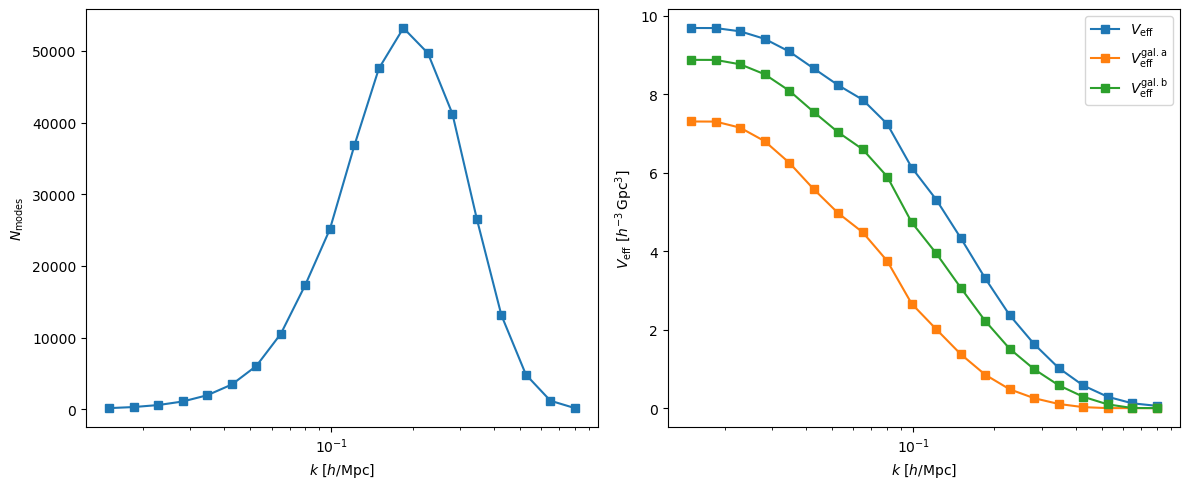

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,5),sharex=True)
ax = axs[0]
ax.plot(ks,Nm,label=r'$N_{\rm modes}$', marker='s')
ax.set_xlabel(r'$k$ [$h/{\rm Mpc}$]')
ax.set_ylabel(r'$N_{\rm modes}$')

ax = axs[1]
ax.plot(ks,Veff/1e9,label=r'$V_{\rm eff}$', marker='s')
ax.plot(ks,Veff_ga/1e9,label=r'$V_{\rm eff}^{\rm gal.a}$', marker='s')
ax.plot(ks,Veff_gb/1e9,label=r'$V_{\rm eff}^{\rm gal.b}$', marker='s')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r'$k$ [$h/{\rm Mpc}$]')
ax.set_ylabel(r'$V_{\rm eff}$ [$h^{-3}\, \mathrm{Gpc}^3$]')
plt.tight_layout()
plt.show()